In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

Test for stability:

In [24]:
sigma = 10
rho = 22
beta = 8/3

## Critical points for rho > 1:
## +- sqrt(b(r-1)), +- sqrt(b(r-1)), r-1

## Stable if
## rho < sigma*(sigma + beta + 3)/(sigma - beta - 1)

print("Stable if rho is less than :",sigma * (sigma + beta + 3)/(sigma - beta - 1))
print(f"Critical points occur at : \n({np.sqrt(beta * (rho - 1))}, {np.sqrt(beta * (rho - 1))}, {rho - 1}), \n({-np.sqrt(beta * (rho - 1))}, {-np.sqrt(beta * (rho - 1))}, {rho - 1})")

Stable if rho is less than : 24.736842105263154
Critical points occur at : 
(7.483314773547883, 7.483314773547883, 21), 
(-7.483314773547883, -7.483314773547883, 21)


For delayed control:

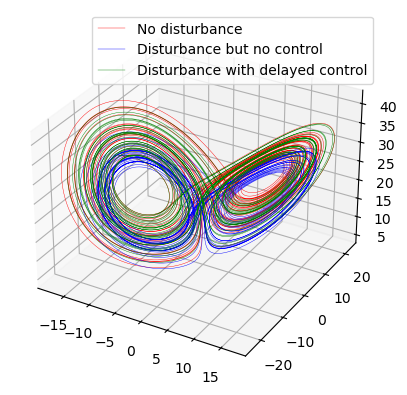

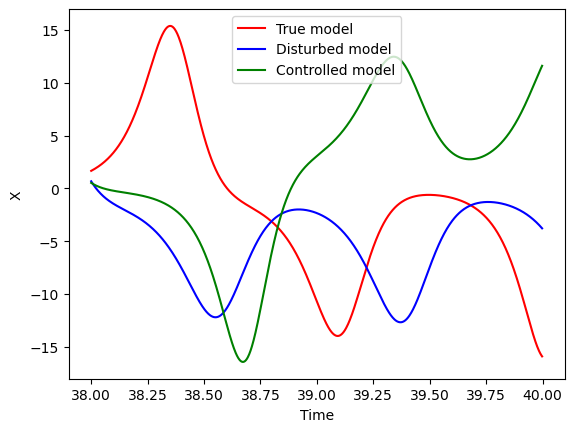

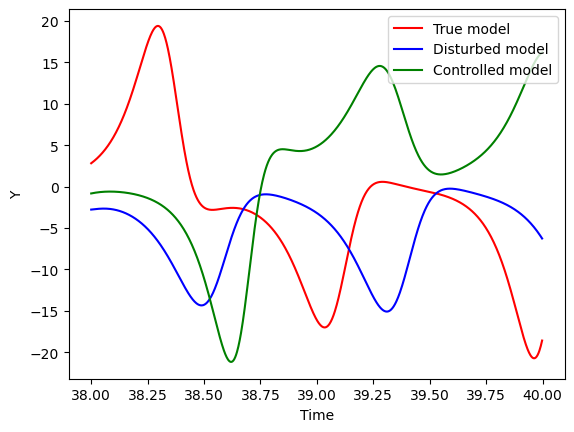

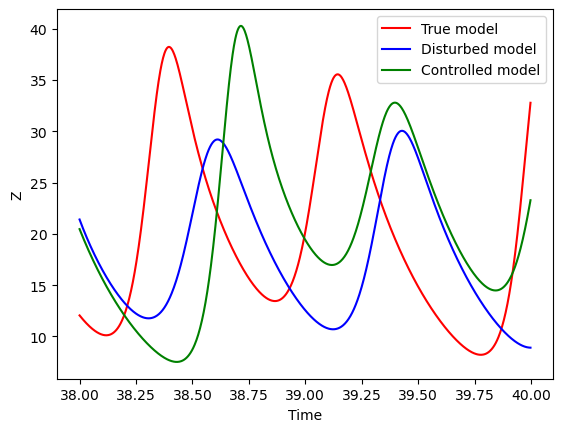

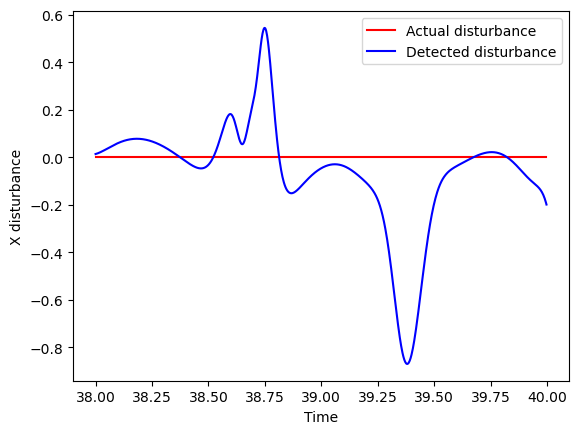

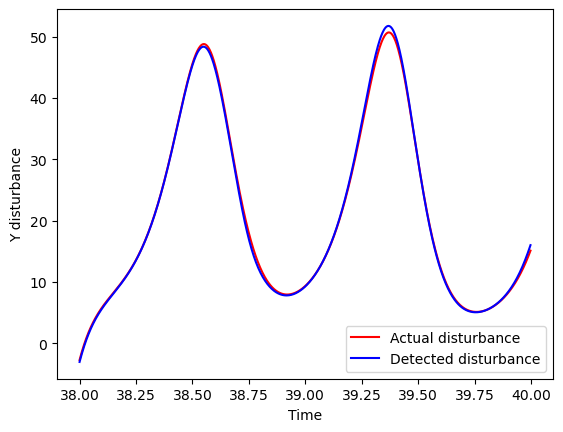

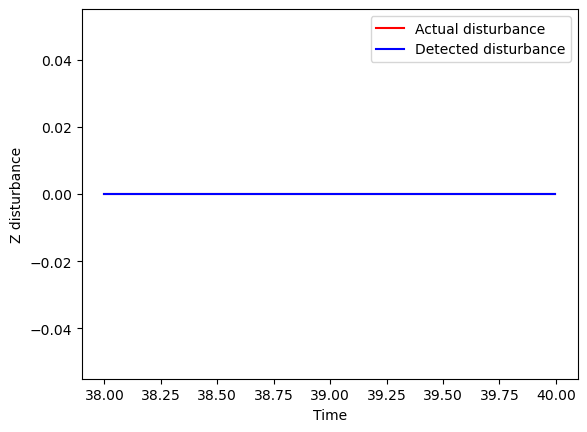

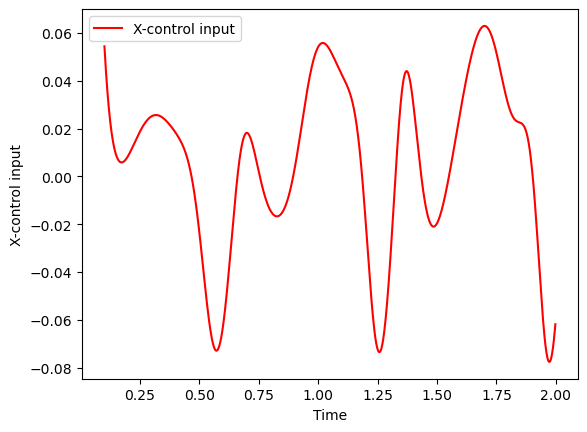

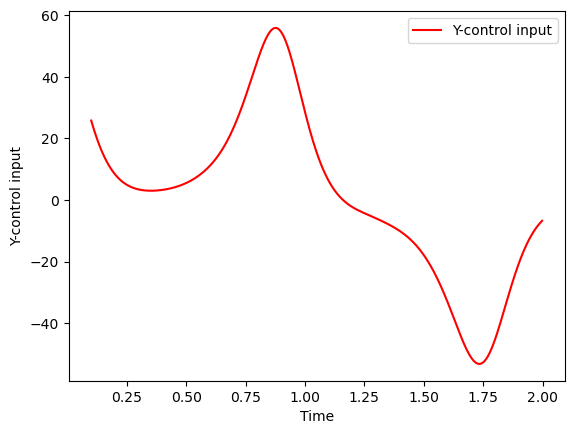

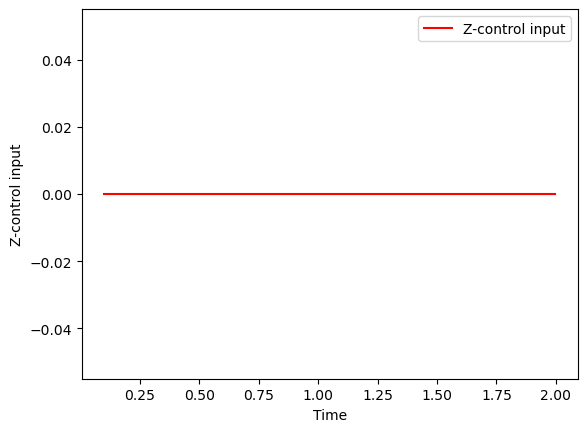

Total energy =  746.5268270805524


In [26]:
## Lorenz system parameters 
sigma = 10
rho = 26
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 200
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 100 * np.cos(0.05 * dt * t)
    fy = 100 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 40
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = -4

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
gpredx = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
gpredy = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
gpredz = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)

## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z


temp = Wout.dot(R[:, -1])

for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    

    ## Disturbance but no control
    
    gynocontrol[t] = disfac * xxnocontrol

    # xrossdot = - yross - zross
    # yrossdot = xross + 0.2 * yross
    # zrossdot = 0.2 + zross * (xross - 5.7)

    # xross = xross + dt * xrossdot
    # yross = yross + dt * yrossdot
    # zross = zross + dt * zrossdot

    # gxnocontrol[t] = 50 * xross 
    # gynocontrol[t] = 50 * yross


    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol



    ## Disturbance with delayed control

    gycontrol[t] = disfac * xxnocontrol
    
    # gxcontrol[t] = 50 * xross 
    # gycontrol[t] = 50 * yross


    ux[t] = temp[0]
    uy[t] = temp[1]
    uz[t] = temp[2]

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    temp = np.array([xxcontrol, yycontrol, zzcontrol])
    r = np.tanh(A.dot(r) + Win.dot(temp) + 1)
    temp = Wout.dot(r)
    gpredx[t] = temp[0] + alpha * vx[t]
    gpredy[t] = temp[1] + alpha * vy[t]
    gpredz[t] = temp[2] + alpha * vz[t]




plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.3, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.3, label = 'Disturbance but no control')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.3, label = 'Disturbance with delayed control')
plt.legend()
plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

plottimerange = np.arange(ntest - 1000, ntest)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xnocontrol[plottimerange],  'b', label = 'Disturbed model')
plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ynocontrol[plottimerange],  'b', label = 'Disturbed model')
plt.plot(testingtimes[plottimerange], ycontrol[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], znocontrol[plottimerange],  'b', label = 'Disturbed model')
plt.plot(testingtimes[plottimerange], zcontrol[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], gxcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredx[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gycontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredy[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gzcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredz[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()


plottimerange = np.arange(50, 1000)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'Actual disturbance')
# plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'b', label = 'Detected disturbance')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('X')
# plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vx[plottimerange], 'r', label = 'X-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vy[plottimerange], 'r', label = 'Y-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vz[plottimerange], 'r', label = 'Z-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-control input')
plt.show()

print("Total energy = ", np.sum(dt * alpha ** 2 * np.sum(vx ** 2 + vy ** 2 + vz ** 2))/Ttest)


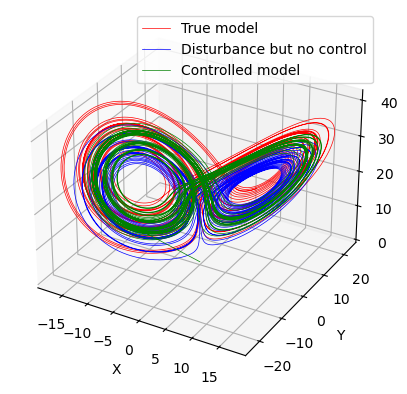

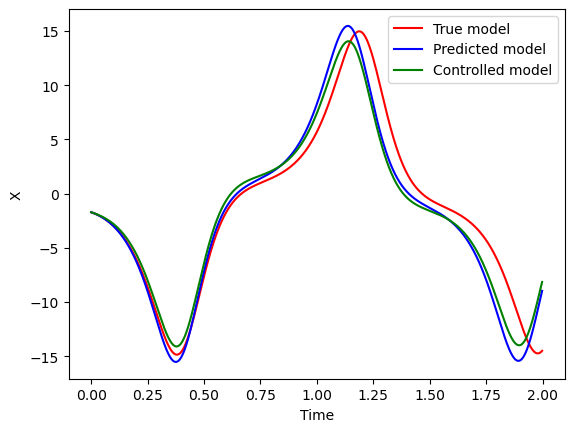

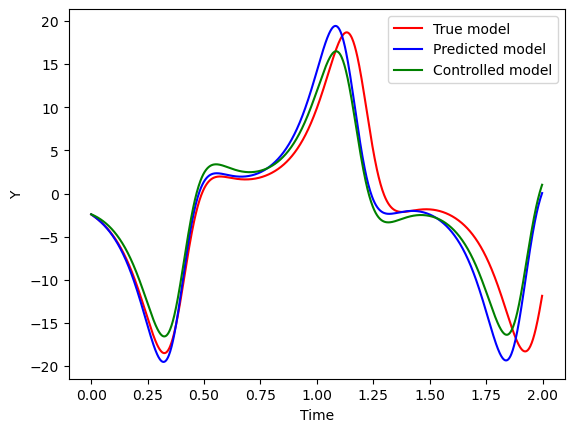

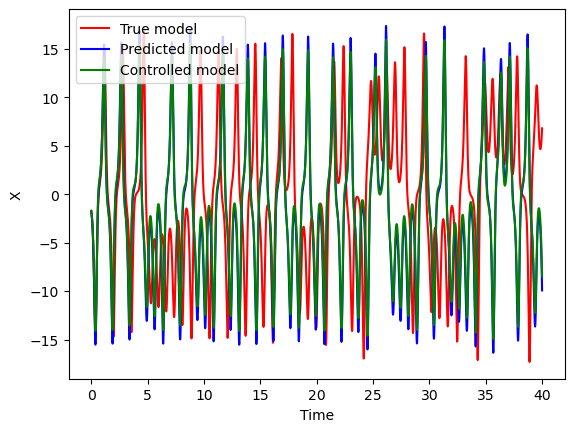

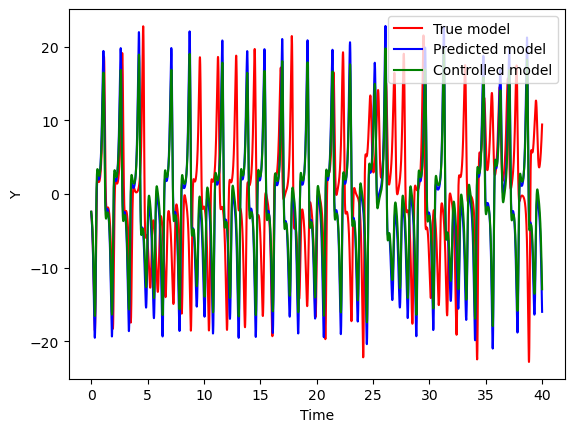

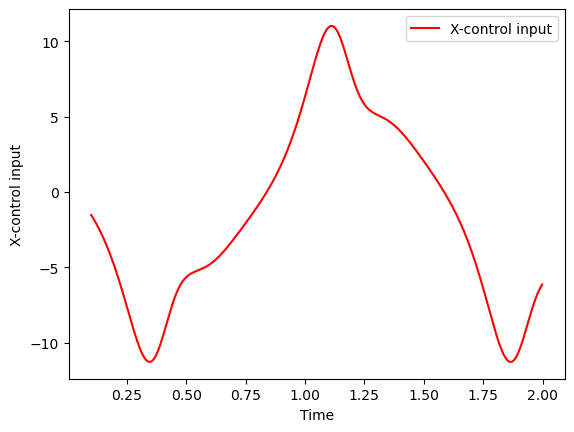

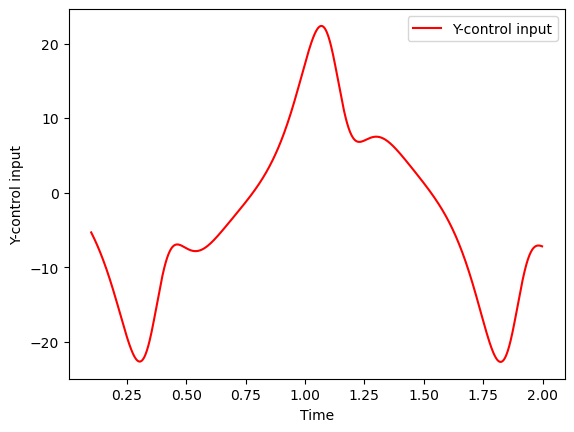

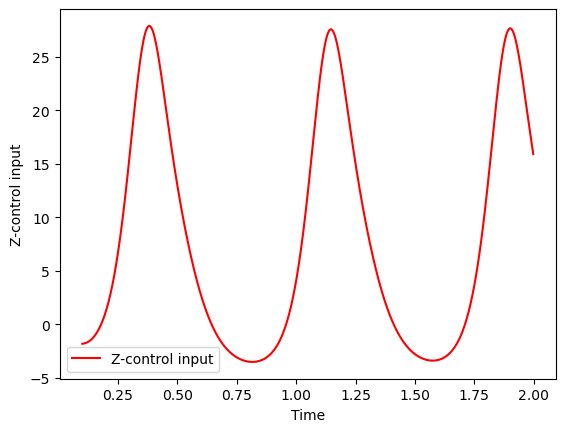

Total energy =  352.6023241618461


In [31]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 26
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 200
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 40
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = -4
controlgain = 1.5/(dt * 100)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)

## For storing control inputs
controlx = np.zeros(ntest + 1)
controly = np.zeros(ntest + 1)
controlz = np.zeros(ntest + 1)


## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * (xxpidp + controlgain * (xxtrack - xxpid))
    yypid += dt * (yypidp + controlgain * (yytrack - yypid))
    zzpid += dt * (zzpidp + controlgain * (zztrack - zzpid))
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid

    controlx[t] =  (xxtrack - xxpid)
    controly[t] =  (yytrack - yypid)
    controlz[t] =  (zztrack - zzpid)





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

# plottimerange = np.arange(0, 1000)



# plt.figure()
# plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
# plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
# plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()




# plt.figure()
# plt.plot(testingtimes[100:200], ypure[100:200], 'r', label = 'True model')
# plt.plot(testingtimes[100:200], ynocontrol[100:200],  'g', label = 'Disturbed model')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controlx[plottimerange], 'r', label = 'X-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controly[plottimerange], 'r', label = 'Y-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controlz[plottimerange], 'r', label = 'Z-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-control input')
plt.show()

print("Total energy = ", 
      np.sum(dt * controlgain ** 2 * np.sum(controlx ** 2 + controly ** 2 + controlz ** 2))/(Ttest))

Initial little disturbance:

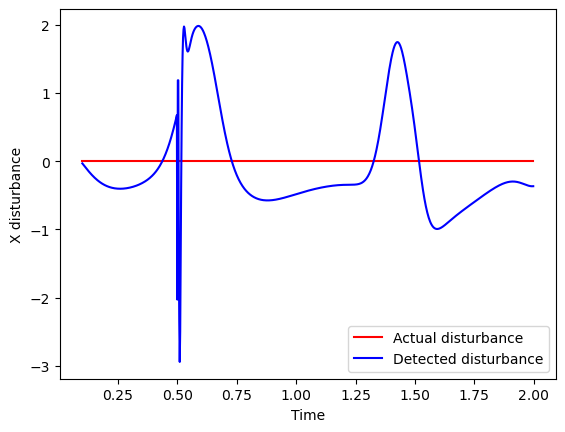

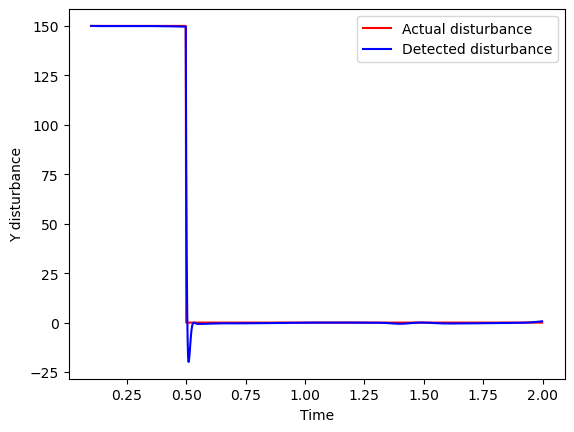

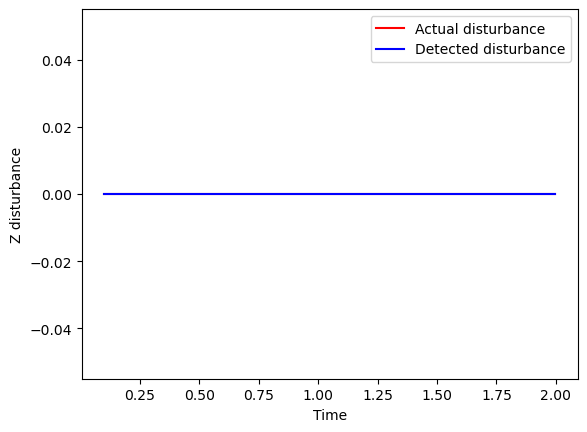

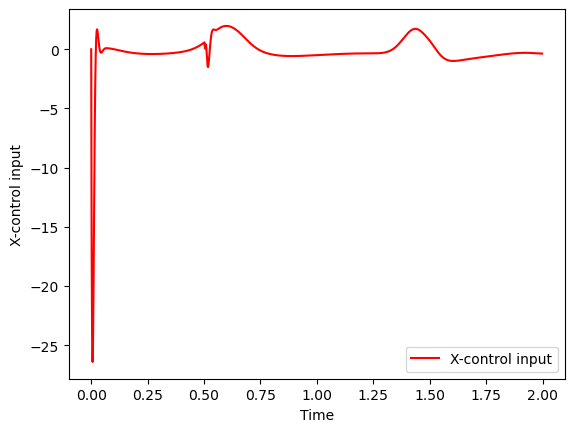

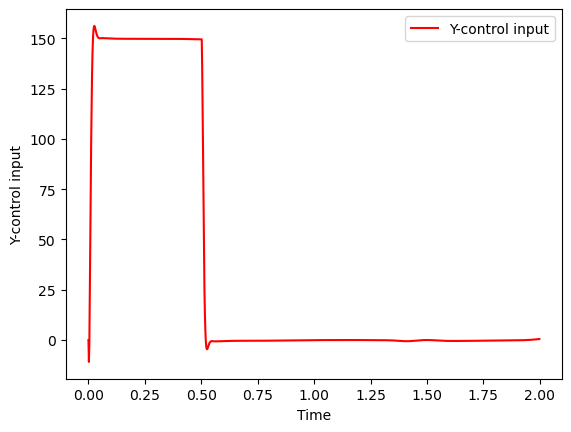

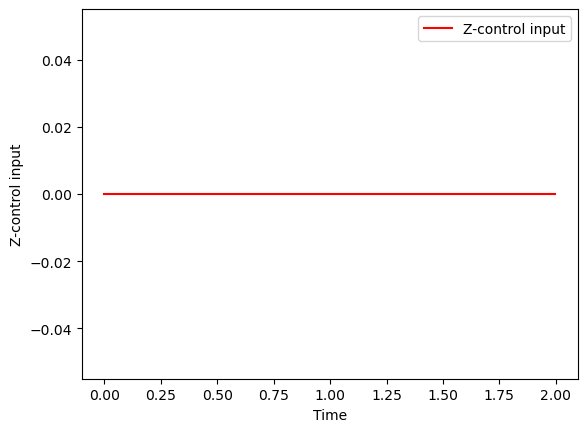

Total energy for delayed control=  1112.7122406357898


In [4]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 200
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 100 * np.cos(0.05 * dt * t)
    fy = 100 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 10

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
gpredx = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
gpredy = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
gpredz = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)

## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z


temp = Wout.dot(R[:, -1])

for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    

    ## Disturbance but no control
    
    if t < 250:
        gynocontrol[t] = 150

    # xrossdot = - yross - zross
    # yrossdot = xross + 0.2 * yross
    # zrossdot = 0.2 + zross * (xross - 5.7)

    # xross = xross + dt * xrossdot
    # yross = yross + dt * yrossdot
    # zross = zross + dt * zrossdot

    # gxnocontrol[t] = 50 * xross 
    # gynocontrol[t] = 50 * yross


    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol



    ## Disturbance with delayed control

    if t < 250:
        gycontrol[t] = 150
    
    # gxcontrol[t] = 50 * xross 
    # gycontrol[t] = 50 * yross


    ux[t] = temp[0]
    uy[t] = temp[1]
    uz[t] = temp[2]

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    temp = np.array([xxcontrol, yycontrol, zzcontrol])
    r = np.tanh(A.dot(r) + Win.dot(temp) + 1)
    temp = Wout.dot(r)
    gpredx[t] = temp[0] + alpha * vx[t]
    gpredy[t] = temp[1] + alpha * vy[t]
    gpredz[t] = temp[2] + alpha * vz[t]




# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

# plt.figure()
# ax = plt.axes(projection = '3d')
# ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
# ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 1000)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], xnocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('X')
# plt.show()


# plt.figure()
# plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], ynocontrol[plottimerange],  'b', label = 'Disturbed model')
# plt.plot(testingtimes[plottimerange], ycontrol[plottimerange],  'g', label = 'Controlled model')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Y')
# plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gxcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredx[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gycontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredy[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y disturbance')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], gzcontrol[plottimerange], 'r', label = 'Actual disturbance')
plt.plot(testingtimes[plottimerange], gpredz[plottimerange],  'b', label = 'Detected disturbance')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z disturbance')
plt.show()


plottimerange = np.arange(0, 1000)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'Actual disturbance')
# plt.plot(testingtimes[plottimerange], xcontrol[plottimerange],  'b', label = 'Detected disturbance')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('X')
# plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vx[plottimerange], 'r', label = 'X-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vy[plottimerange], 'r', label = 'Y-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], alpha * vz[plottimerange], 'r', label = 'Z-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-control input')
plt.show()

print("Total energy for delayed control= ", np.sum(dt * alpha ** 2 * np.sum(vx ** 2 + vy ** 2 + vz ** 2))/Ttest)



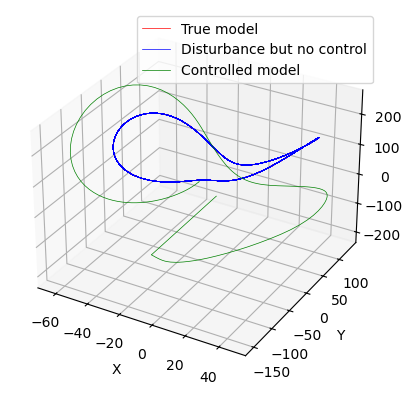

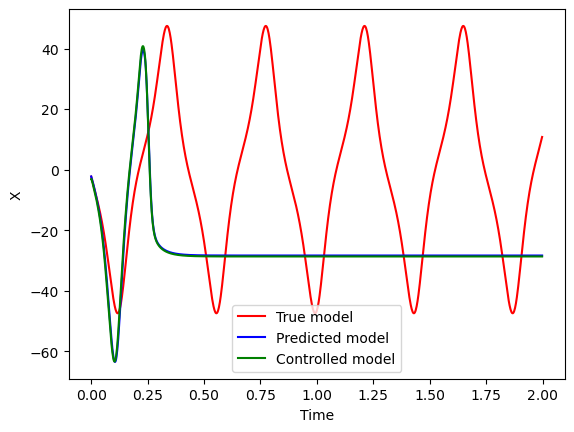

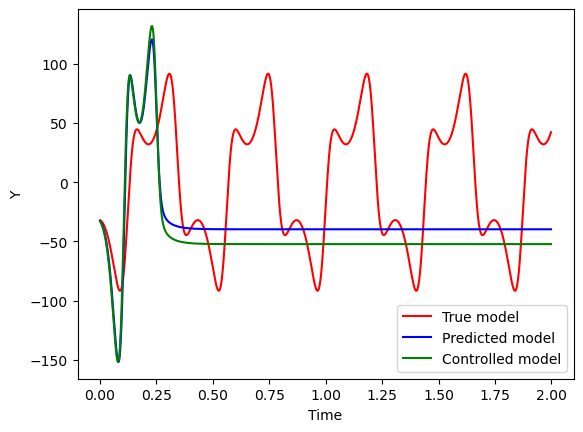

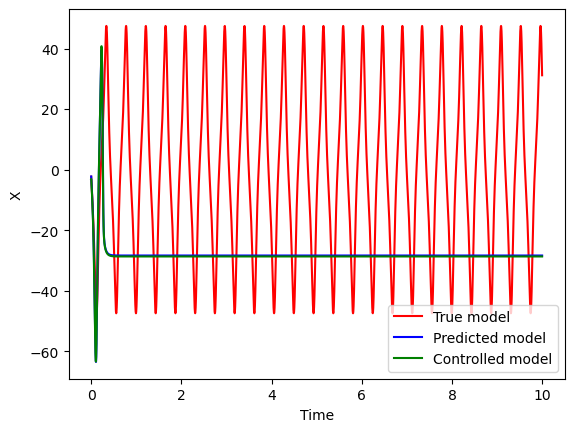

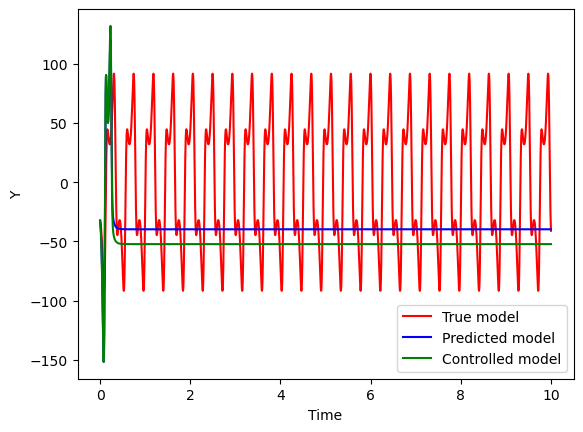

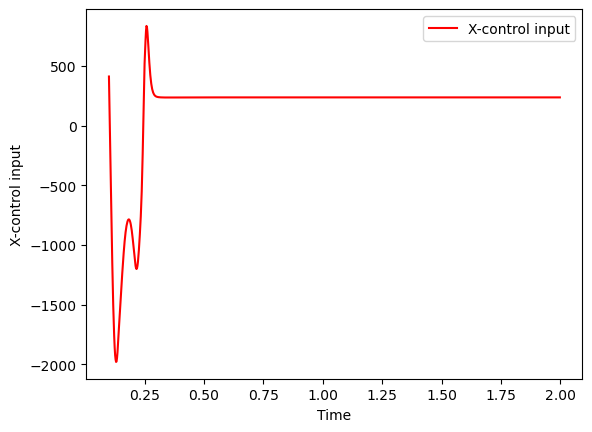

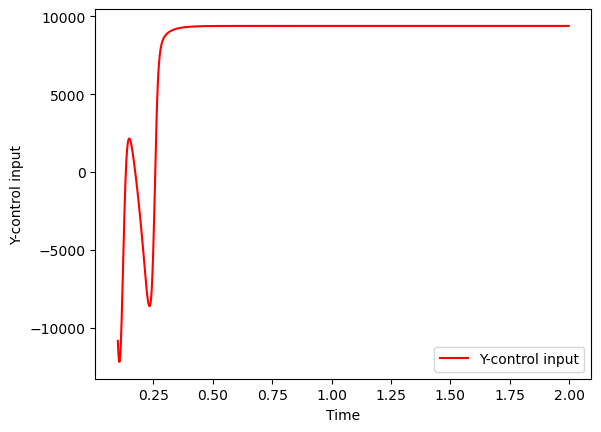

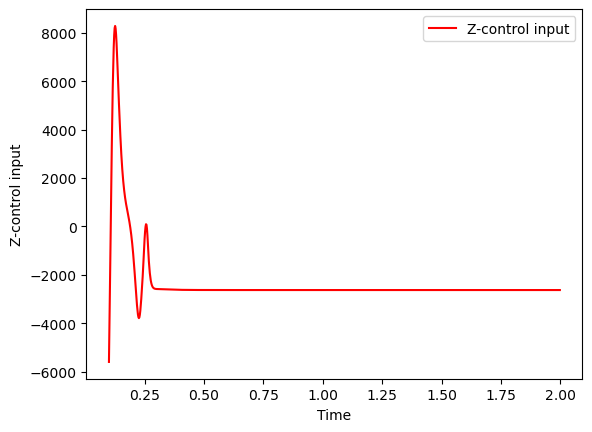

Total energy =  93525548.44011399


In [12]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.0000001              # Lambda for ridge regression

## Simulation parameters
T = 500
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh( A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 10
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)

## For storing control inputs
controlx = np.zeros(ntest + 1)
controly = np.zeros(ntest + 1)
controlz = np.zeros(ntest + 1)

gxnocontrol = np.zeros(ntest)
gynocontrol = np.zeros(ntest)
gznocontrol = np.zeros(ntest)

gxcontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    if t < 250:
        gynocontrol[t] = 0

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control

    if t < 250:
        gycontrol[t] = 0
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + gycontrol[t]
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xxtrack - xxpid)
    yypid += dt * yypidp + controlgain * (yytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (zztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid

    controlx[t] = (xxtrack - xxpid)
    controly[t] = (yytrack - yypid)
    controlz[t] = (zztrack - zzpid)





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

# plottimerange = np.arange(0, 1000)



# plt.figure()
# plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
# plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
# plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()




# plt.figure()
# plt.plot(testingtimes[100:200], ypure[100:200], 'r', label = 'True model')
# plt.plot(testingtimes[100:200], ynocontrol[100:200],  'g', label = 'Disturbed model')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain / dt * controlx[plottimerange], 'r', label = 'X-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain / dt * controly[plottimerange], 'r', label = 'Y-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain / dt * controlz[plottimerange], 'r', label = 'Z-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-control input')
plt.show()

print("Total energy = ", 
      np.sum(controlgain ** 2 * np.sum(controlx ** 2 + controly ** 2 + controlz ** 2))/(dt *Ttest))

Do histogram of neuron states. See if they are pushed to the edges or are normally distributed. Is tanh working too much?